# Homework

**Due Date: 2024-06-27, 23:59**

You will need to succeed in this homework to be eligable for the final exam.

Should in the grey shaded panel not be a "ds24", then you will struggle with your imports -- and we will need to change the kernel: click on kernel/change kernel/ds24

You are allowed to work in teams of 3. Make sure to individually submit the homework, each containing the full names of your team members.


**CAUTION** There are a few training runs in this notebook, which you are of course allowed to change to your heart's content, just make sure that on submission, you change the epoch variable back to the original value. Otherwise the autograder will fail you due to runtime issues with your notebook!


In [1]:
members = []

In [2]:
import torch
import numpy as np
import random

# Task 1: Dataset
As a Machine Learner, you will often need to create custom datasets for your projects.
In this task, you will create a custom dataset class, ShapeDataset, which generates images with random placements of specific shapes. The shapes include horizontal lines, vertical lines, diagonal lines (including off-diagonals in both directions with the exception of the edges) , and 'L' shapes (the L should really only be 3 pixels). Each image will be a 9x9 grid where the shape is represented by 1s and the background is represented by 0s.  Should you not be able to write one of these, just continue by returning the empty image; where the image contains the randomly placed operation index (horizontal=0, vertical=1, diagonal=2, L=3).

In [3]:
def horizontal_line():
    img = np.zeros((9, 9), dtype=int)
    img[random.randrange(9)] = np.full((1, 9), 1, dtype=int)
    return img


def vertical_line():
    img = np.zeros((9, 9), dtype=int)
    img[random.randrange(9)] = np.full((1, 9), 1, dtype=int)
    return img.T


def diagonal_line():
    img = np.zeros((9, 9), dtype=int)
    pixel = (random.randrange(9), random.randrange(2)*8)
    direction_rows = 0
    direction_columns = 0
    if pixel[0] == 0:
        direction_rows = 1
    elif pixel[0] == 8:
        direction_rows = -1
    else:
        direction_rows = (-1) ** (random.randrange(1,3))
    if pixel[1] == 0:
        direction_columns = 1
    elif pixel[1] == 8:
        direction_columns = -1
    pixel_temp = pixel
    while pixel_temp[0] >= 0 and pixel_temp[0] <= 8 and pixel_temp[1] >= 0 and pixel_temp[1] <= 8:
        img[pixel_temp] = 1
        pixel_temp = (pixel_temp[0]+direction_rows, pixel_temp[1]+direction_columns)
    return img


def l_shape():
    img = np.zeros((9, 9), dtype=int)
    pixel = (random.randrange(9), random.randrange(9))
    x, y = 0, 0
    if pixel[0] == 0:
        x = 1
    elif pixel[0] == 8:
        x = 7
    else: 
        x = pixel[0]+((-1) ** (random.randrange(1,3)))
    if pixel[1] == 0:
        y = 1
    elif pixel[1] == 8:
        y = 7
    else: 
        y = pixel[1]+((-1) ** (random.randrange(1,3)))
    diagonal_pixel = (x, y)
    decider = random.randrange(2)
    if decider:
        connection_pixel = (diagonal_pixel[(decider+1) % 2], pixel[decider % 2])
    else:
        connection_pixel = (pixel[decider % 2], diagonal_pixel[(decider+1) % 2])
    img[pixel] = 1
    img[diagonal_pixel] = 1
    img[connection_pixel] = 1
    return img


In [4]:
print(l_shape())

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


Now we can write a dataset class, that returns us our images and labels using our helper functions.

In [5]:
from torch.utils.data import Dataset


class ShapeDataset(Dataset):
    def __init__(self, length):
        self.images = []
        self.labels = []
        for n in range(length):
            rng = random.randrange(4)
            if rng == 0:
                self.images.append(horizontal_line())
                self.labels.append('Horizontal')
            elif rng == 1:
                self.images.append(vertical_line())
                self.labels.append('Vertical')
            elif rng == 2:
                self.images.append(diagonal_line())
                self.labels.append('Diagonal')
            elif rng == 3:
                self.images.append(l_shape())
                self.labels.append('L_shape')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = torch.tensor(img,
                           dtype=torch.float32)  # we make sure that it is a tensor that pytorch can use!
        return img, label

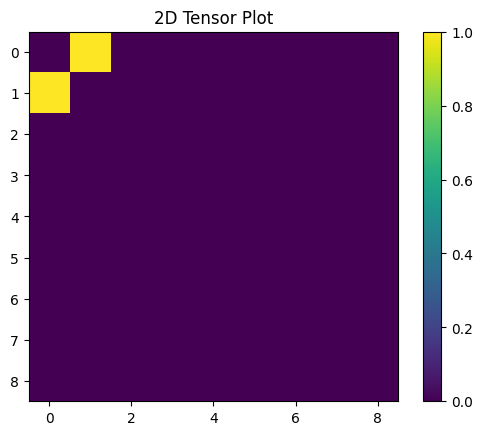

torch.Size([3, 9, 9]) ('Diagonal', 'L_shape', 'L_shape')


In [6]:
# Let's check if your dataset works in a DataLoader:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = ShapeDataset(
    10)  # notice, that the length is in our simulated case only relevant for how many "epochs" the data loader will run
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

for imgs, labels in dataloader:
    # Create the plot
    plt.imshow(imgs[0], cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('2D Tensor Plot')
    plt.show()
    print(imgs.shape, labels)  # notice the batch dimension!
    break

Nice, now that we have a dataset, let us build a classifier capable of learning how to classify the base shapes

# Task 2: Convolution Operation
The task here is to write a simple convolution module with a single filter and calculate the forward pass manually. Make sure not to use any preimplemented `F.conv2d` operation or the nn.Conv2D. We will check that you didn't! Copying the src will be considered plagiarism and disqualify you. 
Of course, you should validate your solution against a F.conv2d from PyTorch to check if you are on the right track.  


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define the SimpleConvolution module from previous example
class SimpleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SimpleConvolution, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Initialize the filter with random values
        # The Parameter is important to let PyTorch know that this tensor should be trained
        self.filter = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))

    def forward(self, x):
        if len(x.size()) == 4:
            batch_size, input_channels, height, width = x.size()
        elif len(x.size()) == 3:
            batch_size, height, width = x.size()
            input_channels = 1
            x = x.unsqueeze(1)
        output = torch.zeros(batch_size, self.out_channels, height-self.kernel_size+1, width-self.kernel_size+1)
        for bs in range(batch_size):
            for o in range(self.out_channels):
                for ih in range(height-self.kernel_size+1):
                    for iw in range(width-self.kernel_size+1):
                        conv_sum = 0
                        for kw in range(self.kernel_size):
                            for kh in range(self.kernel_size):
                                for i in range(input_channels):                                    
                                    conv_sum += x[bs, i, ih+kh, iw+kw] * self.filter[o, i, kh, kw]
                        output[bs, o, ih, iw] = conv_sum
        return output

In [8]:
# Test the implementation
input_tensor = torch.randn(1, 1, 5, 5)  # generate a random input tensor
conv_layer = SimpleConvolution(in_channels=1, out_channels=1, kernel_size=3) # create instance of SimpleConvolution
# Perform the forward pass with the custom implementation.
output_tensor = conv_layer(input_tensor)
# Print the input and output of teh Tensor
print("Input Tensor:")
print(input_tensor)
print("\nOutput Tensor:")
print(output_tensor)
# Validation against PyTorch's F.conv2d
filter_tensor = conv_layer.filter.detach()  # Get the filter from our implementation to use it with F.conv2d
output_tensor_F_conv2d = F.conv2d(input_tensor, filter_tensor) 
# Print validation output
print("\nF.conv2d Output Tensor:")
print(output_tensor_F_conv2d)

Input Tensor:
tensor([[[[ 0.3109, -1.6746,  0.4504, -2.2830, -0.5367],
          [-0.1133,  1.3773, -0.4270, -0.0177,  2.3298],
          [-0.3630,  1.4939, -1.2050, -1.4619,  1.3191],
          [-1.1318, -1.0970, -0.9977, -0.0894,  0.9840],
          [-1.2825,  0.4840,  0.5527,  0.2469, -0.1265]]]])

Output Tensor:
tensor([[[[ 3.7095,  0.5887,  0.1855],
          [-2.7601, -1.1210, -0.3811],
          [ 0.9998,  5.4159,  3.6698]]]], grad_fn=<CopySlices>)

F.conv2d Output Tensor:
tensor([[[[ 3.7095,  0.5887,  0.1855],
          [-2.7601, -1.1210, -0.3811],
          [ 0.9998,  5.4159,  3.6698]]]])


# Task 3: Simple Convolutional Neural Network
Alright, now that we have a dataset and a convolutional module, we can try and learn a simple classifier network and training loop, that 
will help us perfectly classifiy the shapes (in this task, should your own implementation not work, you are allowed to use pre-implemented versions, but how cool would it be if your own operations did the job -- but you probably will want to have more than one filter to learn).

You might find pooling operations helpful, but you can also try without them. 

**ATTENTION** you will need to comment the train call before submission otherwise this will result in a timeout during auto-grading and fail you! Don't make me manually grade you! 

In [9]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes, kernel_size):
        super(SimpleCNN, self).__init__()
        self.conv_layer = SimpleConvolution(in_channels=3, out_channels=16, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(in_features=784, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.relu(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        x = self.softmax(x)
        return x

    def predict(self, x):
        # hint:
        # think about why this function is here and what output your forward should have
        # -- you won't use the predict during your training loop though!
        return torch.argmax(self.forward(x), dim=1)


In [10]:
from torch import optim


def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        for X, y in train_loader:
            print(type(X))
            print(X.size())
            print(len(X.size()))
            optimizer.zero_grad()
            y_hat = model.forward(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch} Loss: {loss.item()}')
        # print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')


In [11]:
model = SimpleCNN(4, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
dataset = ShapeDataset(100)  # notice, that the length is in our simulated case only relevant for how many "epochs" the data loader will run
trainloader = DataLoader(dataset, batch_size=3, shuffle=True)


train(
    model=model,
    train_loader=trainloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100
)

<class 'torch.Tensor'>
torch.Size([3, 9, 9])
3


TypeError: cross_entropy_loss(): argument 'target' (position 2) must be Tensor, not tuple

Let's check if the model did something useful after your training (this part is not graded, but can help you find out what is wrong with your model).

In [ ]:
def evaluate_model_with_confusion_matrix(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.unsqueeze(1)  # Add channel dimension
            outputs = model.predict(images)
            y_pred.extend(outputs.numpy())
            y_true.extend(labels.numpy())

    model.train()
    return y_true, y_pred


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                xticklabels=['Horizontal', 'Vertical', 'Diagonal', 'L-Shape'],
                yticklabels=['Horizontal', 'Vertical', 'Diagonal', 'L-Shape'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Use the modified evaluation function
test_dataset = ShapeDataset(200)  # Generate a separate dataset for testing
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
y_true, y_pred = evaluate_model_with_confusion_matrix(model, test_loader)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)


AttributeError: 'SimpleConvolution' object has no attribute 'predict'

Congratulations to your first successful Neural Network model!

# Task 4: A mysterious Network
Below you will find an intricate network design and you will have to answer some questions about it, so carefully read the code below and maybe consult the documentation of one or the other function. 

Hint: while the Conv2d strides with a kernel over the image to extract a feature map, the Conv2dTranspose does the opposite it takes a feature map, and takes a value from the feature map, multiplies it with each value of the kernel respectively and places them into its output tensor. Think of it as taking in a feature map and producing an image. 




The following plotting function is just a convenience function and can be ignored:) 

In [ ]:
import matplotlib.pyplot as plt


def plot_tensor_batch(tensor):
    # Ensure tensor is CPU tensor and convert to numpy
    tensor = tensor.cpu().numpy()

    # Determine the number of images
    num_images = tensor.shape[0]

    # Calculate the number of columns and rows to display
    num_cols = int(num_images ** 0.5)
    num_rows = (num_images + num_cols - 1) // num_cols

    # Set up the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
    axes = axes.flatten()

    # Loop through all the images in the tensor
    for i, img in enumerate(tensor):
        # Handle grayscale or single channel data
        if img.shape[0] == 1:
            axes[i].imshow(img[0], cmap='gray', interpolation='none')
        else:
            # Convert from CHW to HWC format for plotting
            img = img.transpose(1, 2, 0)
            axes[i].imshow(img, interpolation='none')

        axes[i].axis('off')

    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.layers = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 7 x 7
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 14 x 14
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.layers(input)


class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.layers = nn.Sequential(
            # input is (1 x 28 x 28)
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 14 x 14
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 7 x 7
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)

In [ ]:
# example usage of g
g = G()
vec = torch.randn(2, 100, 1, 1)
new_image = g(vec)

plot_tensor_batch(new_image.detach())



In [ ]:
# example usage of d
d = D()
img = torch.randn(2, 1, 28, 28)
output = d(img)
print(output)

Here we will just quickly collect the MNIST dataset. It comprises of 28x28 images of handwritten digits from 0 to 9.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

In [ ]:
plot_tensor_batch(next(iter(dataloader))[0])

And here comes the intricate wiring of the two networks in their training loop:

In [ ]:
num_epochs = 0  # PLEASE MAKE SURE TO RESET THE VALUE TO ZERO BEFORE SUBMISSION or the autograding might fail you!
# but during this task, you may want to look what this training loop does for you. A value of 50 might already give you a descent idea in a reasonable time :) 

In [ ]:
# Initialize models
g = G()
d = D()

# Loss and optimizer
criterion = nn.BCELoss()
lr = 0.0002
optimizerG = optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(d.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Update d
        optimizerD.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1)
        real_output = d(real_images)
        real_loss = criterion(real_output, real_labels)

        noise = torch.randn(real_images.size(0), 100, 1, 1)
        fake_images = g(noise)
        fake_labels = torch.zeros(real_images.size(0), 1)
        fake_output = d(fake_images.detach())
        fake_loss = criterion(fake_output, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizerD.step()

        # Update g
        optimizerG.zero_grad()
        fake_output = d(fake_images)
        g_loss = criterion(fake_output, real_labels)  # Trick  d
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss D: {d_loss.item()}, Loss G: {g_loss.item()}')



In [ ]:
torch.save(g.state_dict(), 'g.pth')
torch.save(d.state_dict(), 'd.pth')
# this way you can also load the model states back in later

In [ ]:
if False:
    g.load_state_dict(torch.load('g.pth'))
    d.load_state_dict(torch.load('d.pth'))


In [ ]:
# checking out new data from g
with torch.no_grad():
    test_noise = torch.randn(10, 100, 1, 1)
    new_images = g(test_noise)


In [ ]:
plot_tensor_batch(new_images)

Now please answer the following questions, giving all the right answer(s). (e.g. if A and B are correct: answer = set(["A", "B"]))

**What does the nn.Tanh() activation function in the generator's final layer do to the output images?**

A) Scales the output values to the range [0, 1]

B) Scales the output values to the range [-1, 1]

C) Applies a threshold to the output values

D) Normalizes the output values to have zero mean

In [ ]:
answer = None

**What is the purpose of detaching the fake images before passing them to the d during its update?**


A) To allow the g to receive gradients

B) To ensure the g's parameters are updated

C) To prevent the gradients from flowing back to the g during the d's update

D) To reduce the computational load



In [ ]:
answer = None

**Why do we update the d network with real and fake images separately?**

A) To ensure the g does not overfit

B) To reduce the training time

C) To provide the d with balanced examples of real and fake images

D) To increase the complexity of the model

In [ ]:
answer = None

**What is the ultimate goal of this training procedure?**

A) To classify images and distinguish between real and fake images

B) To generate realistic MNIST digit images

C) To reduce the size of the MNIST dataset

D) To improve the accuracy of the MNIST d network



In [ ]:
answer = None

**Why is it important for the g to "trick" the d?**

A) To ensure the d performs well on real images

B) To make the training process faster and more efficient

C) To make the d more robust against adversarial attacks

D) To improve the quality of the new images so they become indistinguishable from real images


In [ ]:
answer = None

**Which of the following use cases could be application cases of a modified vesion of the architecture?**

A) Creating realistic photographs of people who don't exist

B) Predicting house prices based on historical sales data

C) Image-to-image translation, such as turning a photograph into a painting

D) Classifying emails as spam or not spam

E) Generating high-resolution images from low-resolution inputs (super-resolution)

F) Clustering customer data for market segmentation
    
G) Text-to-image synthesis, such as generating images from textual descriptions

H) Generating synthetic medical images for training purposes

I) Predicting stock market trends based on past data

J) Voice conversion to make one person's voice sound like another's

In [ ]:
answer = None

# Task 5: Classification metrics
Take a look at the following confusion matrix. And compute the following metrics:

![Confusion](confusion.jpg)


In [ ]:
true_positives = 60 # = 20 + 15 + 25 
false_positives_A  = 7 # = 5 + 2
accuracy = 60 / 74 # = (20 + 15 + 25) / (20 + 15 + 25 + 5 + 2 + 3 + 1 + 1 +2)
precision_B = 15/19 # = 15/(15+4)

true_positives = 20 + 15 + 25 = 60
false_positives_A = 5 + 2 = 7
accuracy = (20 + 15 + 25) / ()
true_positives_B = 15
false_positives_B = 4
precision_B = 15/(15+4) = 15/19

# Task 6: Regression Tree
 The regression tree in Figure (\ref{fig:regression_tree}) is a model of a particular $min\_samples\_leaf$ value applied to the sklearn exemplary Diabetes dataset. This dataset has 442 observations with the following 10 feature columns: age, sex, body mass index (bmi), average blood pressure (bp) and six blood serum measurements (s1-s6). The target variable is a quantitative measure of disease progression one year after baseline. The statisticians were asked to construct a model that predicted target $y$ from covariates. Two hopes were evident here that the model would produce accurate baseline predictions of response for future patients and also that the form of the model would suggest which covariates were important factors in disease progression.
 
![Tree](regressiontree.jpg)
 


Specify, in which leaf node, the observation (age=41, sex=1, bmi=0.05, bp=0.006, s1=0.02, s2=0.01,
s3=-0.05, s4=-0.33, s5=0.006, s6=0.03) falls (leaf count starts at zero from the leftmost), and report
its predicted disease progression value one year after the baseline.

In [ ]:
node = 7
value = 192.413

Determine, given the plot, what value min_samples_leaf was used at most. 

In [ ]:
min_samples_leaf = 26

**What is the relevance of the min_samples_leaf parameter to the Regression Tree’s model performance?**

A. It prevents overfitting by ensuring leaf nodes have a minimum number of samples, which helps the model generalize better.

B. It controls the maximum depth of the tree.

C. It sets the maximum number of leaf nodes in the tree.

D. It prevents overfitting by stopping the tree from growing too deep.

E. It is a hyperparameter.

In [ ]:
answer = 'A'